# Import libraries

In [1]:
#import os
#os.environ["DCBENCH_CONFIG"] = "/content/drive/MyDrive/Failure_modes_detection/dcbench/dcbench-config.yaml"
import dcbench
import meerkat as mk

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import time
import torch
import math
import os
import yaml
import dcbench
import meerkat as mk
import numpy as np
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.preprocessing import MinMaxScaler
np.set_printoptions(precision = 2)

# Dataset upload

In [3]:
dcbench.config.local_dir = "dc/dcbench_dataset"
dcbench.config.celeba_dir = "dc/base_dataset/celeba"
dcbench.config.imagenet_dir = "dc/base_dataset/imagenet"
dcbench.config.public_backet_name = "dcbench"

In [4]:
dcbench.tasks["slice_discovery"].problems

,alpha,dataset,n_pred_slices,slice_category,slice_names,target_name
p_72776,0.2000,celeba,5,correlation,"[wearing_lipstick=0_young=1, wearing_lipstick=...",wearing_lipstick
p_72793,0.6000,celeba,5,correlation,"[wearing_necklace=0_black_hair=1, wearing_neck...",wearing_necklace
p_72800,0.2000,celeba,5,correlation,"[wearing_necklace=0_brown_hair=1, wearing_neck...",wearing_necklace
p_72799,0.6000,celeba,5,correlation,"[wearing_necklace=0_smiling=1, wearing_necklac...",wearing_necklace
p_72802,0.2000,celeba,5,correlation,"[wearing_necklace=0_wearing_lipstick=1, wearin...",wearing_necklace
...,...,...,...,...,...,...
p_122649,0.2000,imagenet,5,noisy_label,[watch.n.01],timepiece.n.01
p_117333,0.0500,imagenet,5,rare,[cart.n.01],vehicle.n.01
p_118951,0.0500,imagenet,5,rare,[punch.n.02],food.n.01
p_120032,0.0500,imagenet,5,rare,[mushroom.n.05],vegetable.n.01


In [15]:
problem = dcbench.tasks["slice_discovery"].problems["p_118589"]
problem

SliceDiscoveryProblem(artifacts={'activations': 'DataPanelArtifact', 'base_dataset': 'VisionDatasetArtifact', 'clip': 'DataPanelArtifact', 'model': 'ModelArtifact', 'test_predictions': 'DataPanelArtifact', 'test_slices': 'DataPanelArtifact', 'val_predictions': 'DataPanelArtifact'}, attributes={'alpha': 0.049999999999999996, 'dataset': 'imagenet', 'n_pred_slices': 5, 'slice_category': 'rare', 'slice_names': ['cup.n.06'], 'target_name': 'food.n.01'})

In [ ]:
dp = mk.merge(problem["test_slices"], problem["test_predictions"], on="id")
dp = mk.merge(problem["activations"], dp, on="id")
dp = mk.merge(problem["base_dataset"], dp, on="id")
#dp = dp.lz

/home/ubuntu/baonn/venv/lib/python3.8/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/ubuntu/baonn/venv/lib/python3.8/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


,id (PandasSeriesColumn),image (ImageColumn),split_x (PandasSeriesColumn),emb (TensorColumn),slices (NumpyArrayColumn),target (NumpyArrayColumn),probs (ClassificationOutputColumn),split_y (PandasSeriesColumn)
0,000006.jpg,,train,torch.Tensor(shape=torch.Size([512])),"[False, False]",1,"[tensor(0.0004), tensor(0.9996)]",test
1,000127.jpg,,train,torch.Tensor(shape=torch.Size([512])),"[False, False]",0,"[tensor(0.9878), tensor(0.0122)]",test
2,000178.jpg,,train,torch.Tensor(shape=torch.Size([512])),"[False, True]",1,"[tensor(0.0024), tensor(0.9976)]",test
3,000195.jpg,,train,torch.Tensor(shape=torch.Size([512])),"[False, False]",0,"[tensor(0.7697), tensor(0.2303)]",test
4,000271.jpg,,train,torch.Tensor(shape=torch.Size([512])),"[False, True]",1,"[tensor(0.0555), tensor(0.9445)]",test
...,...,...,...,...,...,...,...,...
6216,202432.jpg,,test,torch.Tensor(shape=torch.Size([512])),"[True, False]",0,"[tensor(0.7619), tensor(0.2381)]",test
6217,202486.jpg,,test,torch.Tensor(shape=torch.Size([512])),"[False, False]",1,"[tensor(0.0127), tensor(0.9873)]",test
6218,202518.jpg,,test,torch.Tensor(shape=torch.Size([512])),"[False, False]",1,"[tensor(0.0005), tensor(0.9995)]",test
6219,202565.jpg,,test,torch.Tensor(shape=torch.Size([512])),"[False, False]",0,"[tensor(0.4953), tensor(0.5047)]",test

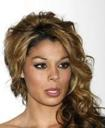
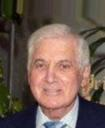
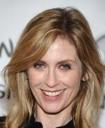
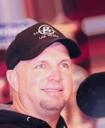
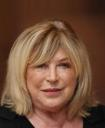
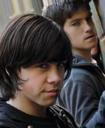
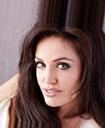
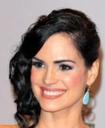
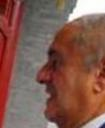
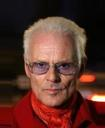

In [11]:
dp

In [8]:
class Graph: 
    # init function to declare class variables
    def __init__(self, adj_matrix):
        self.adj_matrix = adj_matrix
        self.V = self.adj_matrix.shape[0]
        self.adj_list = [(np.where(self.adj_matrix[i] == True)) for i in range(self.V)]
 
    def DFSUtil(self, temp, v, visited):
        # Mark the current vertex as visited
        visited[v] = True
        # Store the vertex to list
        temp.append(v)
 
        # Repeat for all vertices adjacent
        # to this vertex v
        for i in self.adj_list[v][0]:
            if visited[i] == False:
                # Update the list
                temp = self.DFSUtil(temp, i, visited)
        return temp
 
    # Method to retrieve connected components
    # in an undirected graph
    def connectedComponents(self):
        visited = [False for i in range(self.V)]
        cc = []

        for v in range(self.V):
            if visited[v] == False:
                temp = []
                cc.append(self.DFSUtil(temp, v, visited))
        return cc

In [9]:
class DcbenchInstance:
    def __init__(self, instance_id, with_image=False):
        
        self.instance_id = instance_id
        self.with_image = with_image
        try:
            self.problem = dcbench.tasks["slice_discovery"].problems[instance_id]
        except:
            print("Try another instance_id")
        self.dp = mk.merge(self.problem["test_slices"], self.problem["test_predictions"], on="id")
        self.dp = mk.merge(self.problem["activations"], self.dp, on="id")
        if with_image:
            self.dp = mk.merge(self.problem["base_dataset"], self.dp, on="id")
        
        # standardize the embs
        self.emb = np.array(self.dp["emb"])  # N x d
        self.emb = self.emb.reshape(self.emb.shape[0], -1)
        self.N = self.emb.shape[0]
        scalar = StandardScaler()
        # fitting
        scalar.fit(self.emb)
        self.emb = scalar.transform(self.emb)
        self.emb_distance_matrix = euclidean_distances(self.emb, self.emb)
        
        self.dp["emb"] = self.emb
        self.true_label = np.array(self.dp["target"])
        self.pseudo_label = np.argmax(np.array(self.dp["probs"]), axis=1)
        self.failure_id = np.array([i for i in range(self.N) if self.true_label[i] != self.pseudo_label[i]])
        if with_image:
            self.dp = copy.deepcopy(self.dp[["id", "emb", "image"]])
        else:
            self.dp = copy.deepcopy(self.dp[["emb"]])

    def create_instance(self, pattern_size, knn_num):
        with_image = self.with_image
        adj_list = np.argpartition(self.emb_distance_matrix, knn_num + 1)[:, 0:knn_num + 1]
        adj_matrix = np.zeros((self.N, self.N))
        for i in range(self.N):
            adj_matrix[np.ix_([i], adj_list[i])] += 1
            adj_matrix[np.ix_(adj_list[i], [i])] += 1
        adj_matrix = adj_matrix > 1

        failure_adj_matrix = adj_matrix[np.ix_(self.failure_id, self.failure_id)]
        graph = Graph(failure_adj_matrix)
        failure_patterns = []
        cc = graph.connectedComponents()
        for pattern in cc:
            if len(pattern) < pattern_size:
                continue
            failure_patterns.append(self.failure_id[pattern])
        pattern_mask = np.array([-1 for _ in range(self.N)])
        for i, pattern in enumerate(failure_patterns):
            for sample in pattern:
                pattern_mask[sample] = i

        cnt_signal = 0
        cnt_noise = 0
        for i, pattern in enumerate(pattern_mask):
            if pattern == -1 and self.pseudo_label[i] != self.true_label[i]:
                cnt_noise += 1
            if pattern != -1:
                cnt_signal += 1
        if with_image:
            dp = mk.DataPanel(
            {
                "emb": copy.deepcopy(self.emb),
                "image": copy.deepcopy(self.dp["image"]),
                "true_label": copy.deepcopy(self.true_label),
                "pseudo_label": copy.deepcopy(self.pseudo_label),
                "pattern": pattern_mask
            }
            )
        else:
            dp = mk.DataPanel(
            {
                "emb": copy.deepcopy(self.emb),
                "true_label": copy.deepcopy(self.true_label),
                "pseudo_label": copy.deepcopy(self.pseudo_label),
                "pattern": pattern_mask
            }
            )                
        print(np.unique(dp["pattern"], return_counts=True))
        return dp, cnt_signal / cnt_noise, np.unique(dp["pattern"], return_counts=True)[0]

In [10]:
name = "p_122144"
pattern_size = 10
knn = 7
bao  = DcbenchInstance(name, True)
bao_dp, bao_snr, patterns = bao.create_instance(pattern_size, knn)

for pattern in patterns:
    if pattern == -1:
        continue
    file_paths = []
    for i, row in enumerate(bao_dp.lz):
        if row["pattern"] == pattern:
            file_paths.append(row["image"]._data)
                              
    print(file_paths)
    for i, file_path in enumerate(file_paths):
        base_path = os.path.join(str(dcbench.config.celeba_dir), file_path)
        target_folder = "figures/pattern_example" + "/" + name + "_" + str(pattern_size) + "_" + str(knn) + "/" + str(pattern + 1)
        target_file = str(i+1) + ".jpg"
        target_path = os.path.join(target_folder, target_file)
        os.makedirs(os.path.dirname(target_path), exist_ok=True)
        os.system("cp -f " + base_path + " " + target_path)

/home/ubuntu/baonn/venv/lib/python3.8/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/ubuntu/baonn/venv/lib/python3.8/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


FileNotFoundError: [Errno 2] No such file or directory: 'dc/base_dataset/imagenet/ILSVRC/ImageSets/CLS-LOC/train_cls.txt'

,emb (NumpyArrayColumn),image (ListColumn),true_label (NumpyArrayColumn),pseudo_label (NumpyArrayColumn),pattern (NumpyArrayColumn)
0,"np.ndarray(shape=(512,))",,0,1,1
1,"np.ndarray(shape=(512,))",,1,0,1
2,"np.ndarray(shape=(512,))",,0,1,1
3,"np.ndarray(shape=(512,))",,1,0,1
4,"np.ndarray(shape=(512,))",,1,0,1
...,...,...,...,...,...
10,"np.ndarray(shape=(512,))",,1,0,1
11,"np.ndarray(shape=(512,))",,1,0,1
12,"np.ndarray(shape=(512,))",,1,0,1
13,"np.ndarray(shape=(512,))",,1,0,1

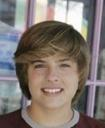
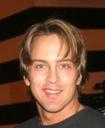
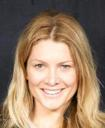
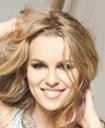
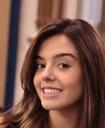
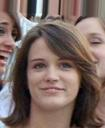
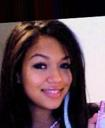
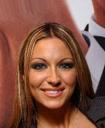
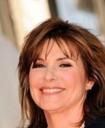
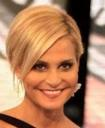

In [24]:
bao_dp[bao_dp["pattern"] == 1]